# Video to Document with GPT-4 Turbo Vision & Azure AI Spatial Analysis Video Retrieval

## Chat with your own video with Azure OpenAI GPT-4 Turbo Vision and Azure AI Spatial Analysis Video Retrieval

### Checklist usecase: from video to text

This solution accelerator presents a detailed framework for analyzing videos, leveraging Azure OpenAI GPT4-Vision with Video Enhancements technology.
It's a crucial resource for businesses across a range of industries, including marketing, media, education, manufacturing, healthcare, and retail.

**Azure AI Spatial Analysis Video Retrieval APIs** are part of Azure AI Vision and enable developers to create an index, add documents (videos and images) to it, and search with natural language. Developers can define metadata schemas for each index and ingest metadata to the service to help with retrieval. Developers can also specify what features to extract from the index (vision, speech) and filter their search based on features.

> All credits to: https://github.com/Azure/gen-cv/blob/main/video/README.md

Documentation:
- https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/how-to/video-retrieval
- https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/reference-video-search
- https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/gpt-with-vision


> Note: Video retrieval using vectorization is preview (version 4.0 preview)

In [1]:
#%pip install opencv-python
#%pip install moviepy

In [2]:
import base64
import cv2
import datetime
import io
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import requests
import sys
import time

from azure.core.credentials import AzureSasCredential
from azure.storage.blob import BlobClient
from dotenv import load_dotenv
from IPython.display import Video, Markdown, HTML
from moviepy.editor import VideoFileClip
from urllib.parse import quote

## 1. Setup

In [3]:
load_dotenv("azure.env")

# 1. Azure OpenAI
AOAI_KEY = os.getenv("AOAI_KEY")
AOAI_ENDPOINT = os.getenv("AOAI_ENDPOINT")

# 2. Azure AI Vision
AZURE_CV_KEY = os.getenv("AZURE_CV_KEY")
AZURE_CV_ENDPOINT = os.getenv("AZURE_CV_ENDPOINT")

# 3. Azure Storage Account
# Check the validatity date and "Add, Create, Write, Delete and List" permissions for the SAS Token
AZURE_SAS_TOKEN = os.getenv("AZURE_SAS_TOKEN")
AZURE_STORAGE_ACCOUNT = os.getenv("AZURE_STORAGE_ACCOUNT")
# Container to store the videos
AZURE_STORAGE_CONTAINER = os.getenv("AZURE_STORAGE_CONTAINER")

In [4]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")


check_openai_version()

Installed OpenAI version: 1.12.0
[OK] OpenAI version 1.12.0 is >= 1.0.0


In [5]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
OpenAI version: 1.12.0


In [6]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 26-Feb-2024 17:14:14


In [7]:
pd.set_option("display.max_colwidth", False)

### GPT-4 Turbo with Vision model

In [8]:
GPT_4V_DEPLOYMENT = "gpt-4TurboVision"  # Your GPT4 Turbo Vision deployed model

In [9]:
GPT_4V_ENDPOINT = f"{AOAI_ENDPOINT}/openai/deployments/{GPT_4V_DEPLOYMENT}\
/extensions/chat/completions?api-version=2023-12-01-preview"

### Directories

In [10]:
AZURE_STORAGE_PATH = "checklist/"  # Directory to create into your blob storage

VIDEO_DIR = "videos"
VIDEO_INDEX = f"ind-{str(datetime.datetime.today().strftime('%d%b%Y-%H%M%S'))}"

In [11]:
print(f"Index to create: {VIDEO_INDEX}")

Index to create: ind-26Feb2024-171414


## 2. Helper functions

In [12]:
def upload_file_to_blob(blob_name: str, source_dir=VIDEO_DIR, file_extension: str = ""):
    """
    Uploads a file to Azure Blob Storage.

    Args:
        blob_name (str): The name of the blob (file) to be uploaded.
        source_dir (str, optional): The directory of the source file. Defaults to VIDEO_DIR.
        file_extension (str, optional): The file extension (including the dot, e.g., '.mp4') to
        be appended to blob_name. Defaults to ''.

    Returns:
        str: The URL of the uploaded blob.

    """
    account_url = "https://{}.blob.core.windows.net/".format(AZURE_STORAGE_ACCOUNT)

    full_blob_name = os.path.join(AZURE_STORAGE_PATH, blob_name + file_extension)
    encoded_blob_name = quote(full_blob_name)  # URL-encode the full_blob_name

    blob_client = BlobClient(
        account_url=account_url,
        container_name=AZURE_STORAGE_CONTAINER,
        blob_name=full_blob_name,
        credential=AzureSasCredential(AZURE_SAS_TOKEN),
        max_block_size=1024 * 1024 * 4,  # 4 MiB
        max_single_put_size=1024 * 1024 * 16,  # 16 MiB
    )

    with open(
        file=os.path.join(source_dir, blob_name + file_extension), mode="rb"
    ) as data:
        blob_client.upload_blob(data=data, overwrite=True, max_concurrency=2)

    return account_url + AZURE_STORAGE_CONTAINER + "/" + encoded_blob_name


def local_videos_to_azure_blob(file_path, video_dir=VIDEO_DIR):
    """
    Upload local videos to Azure Storage Account
    """
    video_path = os.path.join(video_dir, file_path)

    # extract metadata from video file
    with VideoFileClip(video_path) as video:
        duration_mins = round(video.duration / 60, 1)  # Duration in minutes
        fps = round(video.fps)  # Frames per second
        resolution = video.size  # Resolution (width, height)

    file_size_bytes = os.path.getsize(video_path)
    size_mb = round(file_size_bytes / (1024 * 1024), 1)

    # upload video file to blob storage
    blob_url = upload_file_to_blob(file_path, video_dir)

    metadata = {
        "duration_mins": duration_mins,
        "fps": fps,
        "resolution": resolution,
        "document_url": blob_url,
        "size_mb": size_mb,
    }

    return metadata


def list_video_indexes(vision_api_endpoint, vision_api_key):
    """
    List indexes
    """
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes?api-version=2023-05-01-preview"
    headers = {"Ocp-Apim-Subscription-Key": vision_api_key}
    response = requests.get(url, headers=headers)

    return response.json()


def delete_video_index(vision_api_endpoint, vision_api_key, index_name):
    """
    Delete video index
    """
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}?api-version=2023-05-01-preview"
    headers = {
        "Ocp-Apim-Subscription-Key": vision_api_key,
        "Content-Type": "application/json",
    }
    response = requests.delete(url, headers=headers)

    return response


def create_video_index(vision_api_endpoint, vision_api_key, index_name, metadata=False):
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}?api-version=2023-05-01-preview"
    headers = {
        "Ocp-Apim-Subscription-Key": vision_api_key,
        "Content-Type": "application/json",
    }
    data = {"features": [{"name": "vision", "domain": "generic"}, {"name": "speech"}]}

    if metadata:
        data["metadataSchema"] = metadata
    response = requests.put(url, headers=headers, json=data)

    return response


def wait_for_ingestion_completion(
    vision_api_endpoint, vision_api_key, index_name, max_retries=30
):
    """
    Wait ingestion completion
    """
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}/ingestions?api-version=2023-05-01-preview"
    headers = {"Ocp-Apim-Subscription-Key": vision_api_key}
    retries = 0

    while retries < max_retries:
        time.sleep(10)
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            state_data = response.json()
            if state_data["value"][0]["state"] == "Completed":
                print(state_data)
                print("Ingestion completed.")
                print(response)
                return True
            elif state_data["value"][0]["state"] == "Failed":
                print(state_data)
                print("Ingestion failed.")
                return False
        retries += 1

    return False


def get_indexed_video_documents(vision_api_endpoint, vision_api_key, index_name):
    """
    Get indexed videos
    """
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}/documents?api-version=2023-05-01-preview&$top=30"
    headers = {
        "Ocp-Apim-Subscription-Key": vision_api_key
    }  # , "Content-Type": "application/json"}
    response = requests.get(url, headers=headers)

    return response


def find_scene(queryText="", featureFilters=["vision", "speech"]):
    """
    Searches text over vision and/or speech features of an indexed video. It is also called frame locator or video
    retrieval api.
    It returns the relevant frames based on the text input and adname.

    Args:
        queryText: Free text input to search in "vision" and "speech" features
        featureFilters: Video features to search a given text, it is possible to select both or only one of "vision"
        and "speech"
    Returns:
        query_result : Response returned from video retrieval api, which is a list of most relevant frames with their
        confidence scores.
    """
    url = (
        AZURE_CV_ENDPOINT
        + "/computervision/retrieval/indexes/"
        + VIDEO_INDEX
        + ":queryByText?api-version=2023-05-01-preview"
    )

    headers = {
        "Content-type": "application/json",
        "Ocp-Apim-Subscription-Key": AZURE_CV_KEY,
    }

    body = {
        "queryText": queryText,
        "dedup": True,
        "filters": {"featureFilters": featureFilters},
    }

    query_result = None

    try:
        r = requests.post(url, json=body, headers=headers)
        query_result = r.json()
    except Exception as error:
        print("Video search operation failed ")
        print(error)

    return query_result


def extract_frame(video_path, timestamp):
    """
    Extract a frame from a video at a given timestamp.
    """
    try:
        # Handle timestamps with fractional seconds
        h, m, s = timestamp.split(":")
        s, ms = (s.split(".") + ["0"])[
            :2
        ]  # Split seconds and milliseconds, default ms to '0' if not present
        frame_time = (int(h) * 3600 + int(m) * 60 + int(s)) * 1000 + int(
            ms[:3]
        )  # Convert to milliseconds

        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_MSEC, frame_time)

        success, frame = cap.read()

        if success:
            return cv2.cvtColor(
                frame, cv2.COLOR_BGR2RGB
            )  # Convert color to RGB for matplotlib

    except Exception as e:
        print(f"Error extracting frame: {e}")

    return None


def video_chat(
    video_url,
    document_id,
    user_prompt,
    sas_token=AZURE_SAS_TOKEN,
    video_index=VIDEO_INDEX,
    gpt_4v_endpoint=GPT_4V_ENDPOINT,
    openai_api_key=AOAI_KEY,
    azure_cv_endpoint=AZURE_CV_ENDPOINT,
    azure_cv_key=AZURE_CV_KEY,
):
    """
    Video chat using Azure OpenAI GPT-4 Turbo with Vision and Azure AI Vision
    """
    headers = {"Content-Type": "application/json", "api-key": openai_api_key}

    payload = {
        "model": "gpt-4-vision-preview",
        "enhancements": {"video": {"enabled": True}},
        "dataSources": [
            {
                "type": "AzureComputerVisionVideoIndex",
                "parameters": {
                    "computerVisionBaseUrl": f"{azure_cv_endpoint}/computervision",
                    "computerVisionApiKey": azure_cv_key,
                    "indexName": video_index,
                    "videoUrls": [f"{video_url}?{sas_token}"],
                },
            }
        ],
        "messages": [
            {
                "role": "system",
                "content": "You are a helpful assistant to analyze images and videos",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": user_prompt},
                    {"type": "acv_document_id", "acv_document_id": document_id},
                ],
            },
        ],
        "max_tokens": 1000,
        "temperature": 0,
        "seed": 1,
    }

    try:
        response = requests.post(gpt_4v_endpoint, headers=headers, json=payload)
        response.raise_for_status()
        content = response.json()["choices"][0]["message"]["content"]
        return content

    except requests.RequestException as e:
        raise SystemExit(f"Failed to make the request. Error: {e}")


def display_tiles(matches_df, nrows=2, ncols=3, figsize=(16, 9)):
    """
    Display videos tiles
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=100)
    axes = axes.flatten()

    for i, (ax, (_, row)) in enumerate(zip(axes, matches_df.iterrows())):
        video_path = f"{VIDEO_DIR}/{row['documentId']}"
        timestamp = row["best"]
        frame = extract_frame(video_path, timestamp)

        if frame is not None:
            ax.imshow(frame)
        else:
            ax.imshow(
                np.zeros((100, 100, 3), dtype=np.uint8)
            )  # Display an empty black frame

        title = f"Top {i+1}, (score: {row['relevance']:.3f}) - Video id: {row['documentId']}"

        # Adjusting the timestamp format to remove sub-second information
        start = row["start"].split(".")[0] if "start" in row else None
        end = row["end"].split(".")[0] if "end" in row else None
        subtitle = f"{start} - {end}" if start and end else "Timestamp not available"

        ax.set_title(f"{title}\n{subtitle}", fontsize=10, pad=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def image_to_html(image, format="jpeg"):
    """
    Image to HTML
    """
    buffer = io.BytesIO()
    plt.imsave(buffer, image, format=format)
    data_uri = base64.b64encode(buffer.getvalue()).decode("utf-8")

    return f'<img src="data:image/{format};base64,{data_uri}" width="200">'


def index_video(video):
    """
    Function to structure video data for indexing
    """
    return {
        "mode": "add",
        "documentId": video["id"],
        "documentUrl": video["document_url"] + "?" + AZURE_SAS_TOKEN,
        "metadata": {
            "filename": video["filename"],
            "duration_mins": str(video["duration_mins"]),
            "size_mb": str(video["size_mb"]),
            "resolution": str(video["resolution"]),
            "fps": str(video["fps"]),
        },
    }


def get_indexes():
    """
    List of existing indexes
    """
    print("List of existing indexes:")
    indexes = list_video_indexes(AZURE_CV_ENDPOINT, AZURE_CV_KEY)
    index_names = [index["name"] for index in indexes["value"]]
    print(index_names)

    return index_names


def delete_index(index_to_delete):
    """
    Delete index
    """
    print(f"Deleting the index {index_to_delete}")
    response = delete_video_index(AZURE_CV_ENDPOINT, AZURE_CV_KEY, index_to_delete)

    if response.status_code == 204:
        print("Done")
    else:
        print("Error")

## 3. Example

In [13]:
!ls $VIDEO_DIR/*.* -lh

-rwxrwxrwx 1 root root 7.2M Feb  6 15:25 'videos/How To Do The WHO Surgical Safety Checklist.mp4'


In [14]:
video_files = [
    filename for filename in os.listdir(VIDEO_DIR) if filename.lower().endswith(".mp4")
]

# Create DataFrame with id column from video files
video_df = pd.DataFrame({"id": video_files})

# Apply the local_videos_to_azure_blob function directly
metadata_df = video_df["id"].apply(local_videos_to_azure_blob)

# Convert the dictionary to a DataFrame and join with the original DataFrame
metadata_df = pd.DataFrame(metadata_df.tolist())
video_df = video_df.join(metadata_df)
video_df["filename"] = video_df["id"]

display(video_df)

,id,duration_mins,fps,resolution,document_url,size_mb,filename
0,How To Do The WHO Surgical Safety Checklist.mp4,3.7,25,"[640, 360]",https://azurestorageaccountsr.blob.core.windows.net/videos/checklist/How%20To%20Do%20The%20WHO%20Surgical%20Safety%20Checklist.mp4,7.2,How To Do The WHO Surgical Safety Checklist.mp4


In [15]:
# list existing indexes
indexes = list_video_indexes(AZURE_CV_ENDPOINT, AZURE_CV_KEY)
index_names = [index["name"] for index in indexes["value"]]

In [16]:
# Delete existing index
print("Trying to delete the index...\n")

response = delete_video_index(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX)
print("Status code:", response.status_code)  # 204 expected if index exist

Trying to delete the index...

Status code: 204


In [17]:
print("Creating the index...\n")

# define additional metadata information
metadata = {
    "language": "en",
    "fields": [
        {"name": "filename", "searchable": False, "filterable": True, "type": "string"},
        {
            "name": "duration_mins",
            "searchable": False,
            "filterable": True,
            "type": "string",
        },
        {"name": "size_mb", "searchable": False, "filterable": True, "type": "string"},
        {
            "name": "resolution",
            "searchable": False,
            "filterable": True,
            "type": "string",
        },
        {"name": "fps", "searchable": False, "filterable": True, "type": "string"},
    ],
}

# create index
response = create_video_index(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX, metadata)

print(f"Status code: {response.status_code}\n")
print(response.text)
print("\nDone")

Creating the index...

Status code: 201

{"name":"ind-26feb2024-171414","metadataSchema":{"language":"en","fields":[{"name":"filename","searchable":false,"filterable":true,"type":"string"},{"name":"duration_mins","searchable":false,"filterable":true,"type":"string"},{"name":"size_mb","searchable":false,"filterable":true,"type":"string"},{"name":"resolution","searchable":false,"filterable":true,"type":"string"},{"name":"fps","searchable":false,"filterable":true,"type":"string"}]},"userData":{},"features":[{"name":"vision","modelVersion":"2022-04-11","domain":"generic"},{"name":"speech","modelVersion":"2023-06-30","domain":"generic"}],"eTag":"\"a30922ee1556464ea3742d6c409f51b7\"","createdDateTime":"2024-02-26T17:14:16.8981394Z","lastModifiedDateTime":"2024-02-26T17:14:16.8981394Z"}

Done


In [18]:
INGESTION_NAME = f"{VIDEO_INDEX}-ingestion"

url = f"{AZURE_CV_ENDPOINT}/computervision/retrieval/indexes/{VIDEO_INDEX}/ingestions/{INGESTION_NAME}?api-version=2023-05-01-preview"
headers = {
    "Ocp-Apim-Subscription-Key": AZURE_CV_KEY,
    "Content-Type": "application/json",
}

videos = [index_video(video) for _, video in video_df.iterrows()]
body = {"videos": videos, "includeSpeechTranscript": True, "moderation": False}

r = requests.put(url, json=body, headers=headers)
result = r.json()
result

{'name': 'ind-26feb2024-171414-ingestion',
 'state': 'Running',
 'batchName': '72e42d60-2345-4d4e-80a7-4dcf7acc1dd1',
 'createdDateTime': '2024-02-26T17:14:17.3512639Z',
 'lastModifiedDateTime': '2024-02-26T17:14:17.6793728Z'}

,thumbnail,filename,duration_mins,size_mb,resolution,fps,createdDateTime,documentUrl
0,,How To Do The WHO Surgical Safety Checklist.mp4,3.7,7.2,"[640, 360]",25,2024-02-26T17:14:17.3512639Z,https://azurestorageaccountsr.blob.core.windows.net/videos/checklist/How%20To%20Do%20The%20WHO%20Surgical%20Safety%20Checklist.mp4

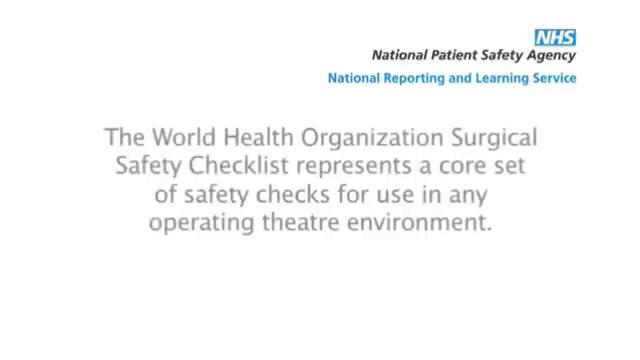

In [19]:
# show indexed videos
response = get_indexed_video_documents(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX)

indexed_videos_df = pd.DataFrame.from_records(response.json()["value"])
metadata_fields = pd.json_normalize(indexed_videos_df["metadata"])
indexed_videos_df = pd.concat([indexed_videos_df, metadata_fields], axis=1)
del indexed_videos_df["metadata"]

# Generate thumbnails and add them to the df
thumbnails = []

for url in indexed_videos_df["documentUrl"]:
    video_url = url + "?" + AZURE_SAS_TOKEN
    thumbnail = extract_frame(video_url, "00:00:10")
    thumbnails.append(image_to_html(thumbnail) if thumbnail is not None else "")

indexed_videos_df["thumbnail"] = thumbnails

# Create HTML table
html_table = indexed_videos_df[
    [
        "thumbnail",
        "filename",
        "duration_mins",
        "size_mb",
        "resolution",
        "fps",
        "createdDateTime",
        "documentUrl",
    ]
].copy()
html_table = html_table.to_html(escape=False)

display(HTML(html_table))

## 4. Chat based video analysis

In [20]:
video_file = os.path.join(VIDEO_DIR, video_files[0])

print(f"Video file: {video_file}")
Video(video_file, width=640)

Video file: videos/How To Do The WHO Surgical Safety Checklist.mp4


In [22]:
top_match_id = "How To Do The WHO Surgical Safety Checklist.mp4"

video_url = indexed_videos_df[indexed_videos_df["documentId"] == top_match_id][
    "documentUrl"
].values[0]

video_url_sas = video_url + "?" + AZURE_SAS_TOKEN

display(
    Video(
        video_url_sas, embed=False, width=800, html_attributes="controls muted autoplay"
    )
)

In [26]:
questions = [
    "Provide a summary of the video",
]

for question in questions:
    print(f"Question: {question}")
    response = video_chat(
        video_url=video_url, document_id=top_match_id, user_prompt=question
    )
    print("\033[1;31;34m")
    print(response)
    print("\033[0m")

Question: Provide a summary of the video

The video demonstrates the use of the World Health Organization Surgical Safety Checklist in a medical setting, as adapted for England and Wales. It shows a team of healthcare professionals, including nurses and surgeons, conducting a pre-operative verification process with a patient named Joanna Davidson, who is scheduled for a laparoscopic cholecystectomy. The checklist includes confirming the patient's identity, the surgical procedure, and ensuring that all necessary equipment and information are in place before the surgery begins. The team also discusses potential risks, such as blood loss and the need for conversion to open surgery. The video emphasizes the importance of the checklist in ensuring patient safety and improving communication among the surgical team.



In [38]:
questions = [
    "Show a table with timestamps and detailed descriptions of the scenes",
    "Do we have any brand in the video?",
]

for question in questions:
    display(Markdown(f"**{question}**"))
    response = video_chat(video_url=video_url, document_id=top_match_id, user_prompt=question)
    display(Markdown(response))

**Show a table with timestamps and detailed descriptions of the scenes**

| Timestamp | Scene Description |
|-----------|-------------------|
| 00:00:00  | Title screen displaying "World Health Organization Surgical Safety Checklist (adapted for England and Wales)" with the NHS logo and National Patient Safety Agency information. |
| 00:00:06  | Transition screen with the NHS logo and text "How to do the Checklist". |
| 00:00:23  | Information screen stating "This Checklist contains the core content but can be adapted locally or for specific specialties." |
| 00:00:39  | A nurse and another healthcare professional standing beside a patient's bed, with the nurse holding a document and asking the patient to confirm their name and date of birth. |
| 00:00:54  | The nurse continues to interact with the patient, mentioning the need to check that the patient has signed the consent form. |
| 00:01:02  | The nurse informs the patient that the surgical site is not marked because it is not applicable. |
| 00:01:14  | The nurse asks the patient about any known allergies, to which the patient responds "No." |
| 00:01:30  | A view of the Surgical Safety Checklist on a clipboard, with various checks and information being reviewed. |
| 00:01:43  | Scene in the operating room with the surgical team around the patient, and the name and title "Paul Ziprin Consultant Surgeon" displayed. |
| 00:01:56  | The surgical team is gathered around the patient, and a voice requests verbal confirmation of the patient's name and details of the planned procedure. |
| 00:02:02  | The team discusses the expected blood loss, which is minimal. |
| 00:02:09  | A question is posed about any critical steps in the procedure. |
| 00:02:21  | Confirmation of the sterility of the instrumentation is given. |
| 00:02:28  | The team discusses having an open set on standby. |
| 00:02:40  | A team member confirms that glycemic control is not indicated for the patient. |
| 00:02:50  | The Surgical Safety Checklist is shown again, focusing on the "SIGN OUT" section. |
| 00:03:01  | The team confirms that instrument, swabs, and sharps counts are complete. |
| 00:03:23  | Closing screen with URLs for additional information on patient safety and surgical safety. |
| 00:03:31  | Credits screen thanking various organizations and individuals for their contributions to the video. |
| 00:03:40  | Copyright notice from the National Patient Safety Agency, stating the material is for educational and non-commercial use. |

**Do we have any brand in the video?**

Yes, there is a brand present in the video. The brand is "NHS," which stands for the National Health Service in the United Kingdom. It is visible in the logo displayed in the top left corner of the images at timestamps 00:00:00, 00:00:06, 00:00:11, 00:00:23, and throughout the video. The NHS logo is associated with the National Patient Safety Agency (NPSA), as seen in the images.

In [39]:
questions = [
    "Show a table with timestamps and detailed descriptions of the scenes in a json format",
    "Do we have any brand in the video?",
]

for question in questions:
    display(Markdown(f"**{question}**"))
    response = video_chat(video_url=video_url, document_id=top_match_id, user_prompt=question)
    display(Markdown(response))

**Show a table with timestamps and detailed descriptions of the scenes in a json format**

```json
[
    {
        "timestamp": "00:00:00",
        "description": "Title screen with text 'World Health Organization Surgical Safety Checklist (adapted for England and Wales)' displayed."
    },
    {
        "timestamp": "00:00:06",
        "description": "Screen with text 'How to do the Checklist' under the NHS logo."
    },
    {
        "timestamp": "00:00:23",
        "description": "Information screen stating 'This Checklist contains the core content but can be adapted locally or for specific specialties.'"
    },
    {
        "timestamp": "00:00:39",
        "description": "A nurse and another healthcare professional standing beside a patient's bed, nurse is holding a paper and asking the patient to confirm name and date of birth."
    },
    {
        "timestamp": "00:00:54",
        "description": "Nurse is checking the consent form with the patient in the hospital room."
    },
    {
        "timestamp": "00:01:02",
        "description": "Nurse informs the patient that the surgical site is not marked because it is not applicable."
    },
    {
        "timestamp": "00:01:14",
        "description": "Nurse asks the patient about any known allergies."
    },
    {
        "timestamp": "00:01:30",
        "description": "A view of the Surgical Safety Checklist displayed on a screen."
    },
    {
        "timestamp": "00:01:43",
        "description": "Operating room scene with medical staff around the patient, and a name tag identifying 'Paul Ziprin Consultant Surgeon'."
    },
    {
        "timestamp": "00:01:56",
        "description": "Medical staff in the operating room with a nurse asking for verbal confirmation of the patient's name, procedure, site, and position planned."
    },
    {
        "timestamp": "00:02:02",
        "description": "Operating room scene where a nurse is confirming the expected blood loss with the medical team."
    },
    {
        "timestamp": "00:02:09",
        "description": "Medical team discussing the critical steps of the surgery."
    },
    {
        "timestamp": "00:02:21",
        "description": "Nurse confirms the sterility of the instrumentation with the surgical team."
    },
    {
        "timestamp": "00:02:28",
        "description": "Operating room scene where the team discusses having an open set on standby."
    },
    {
        "timestamp": "00:02:40",
        "description": "Discussion about glycemic control during the surgery."
    },
    {
        "timestamp": "00:02:50",
        "description": "Screen showing the 'SIGN OUT' section of the Surgical Safety Checklist."
    },
    {
        "timestamp": "00:03:01",
        "description": "Operating room scene where the nurse confirms that instrument, swabs, and sharps counts are complete."
    },
    {
        "timestamp": "00:03:23",
        "description": "Screen displaying other sources of information with web addresses."
    },
    {
        "timestamp": "00:03:31",
        "description": "Credits screen thanking various organizations including the World Health Organization and Imperial College London."
    },
    {
        "timestamp": "00:03:40",
        "description": "Copyright notice for the National Patient Safety Agency material."
    }
]
```

**Do we have any brand in the video?**

Yes, there is a brand present in the video. The brand is "NHS," which stands for the National Health Service in the United Kingdom. It is visible in the images as part of the National Patient Safety Agency (NPSA) logo and the mention of the NHS website. The NHS is a publicly funded healthcare system in the UK, and the NPSA is a part of the NHS focused on improving patient safety.

In [40]:
questions = [
    "Provide a checklist from the described steps from the video",
    "Show a table with timestamps and detailed descriptions of these steps:",
]

for question in questions:
    display(Markdown(f"**{question}**"))
    response = video_chat(video_url=video_url, document_id=top_match_id, user_prompt=question)
    display(Markdown(response))

**Provide a checklist from the described steps from the video**

Checklist from the described steps in the video:

1. **Sign In (before induction of anesthesia)**
   - Confirm patient identity, site, procedure, and consent.
   - Verify the surgical site/marking.
   - Check anesthesia machine and medication.
   - Confirm patient allergy status.
   - Assess airway and risk of aspiration.
   - Anticipate blood loss.

2. **Time Out (before start of surgical intervention)**
   - Introduce all team members by name and role.
   - Confirm patient's name, procedure, and site.
   - Review anticipated blood loss.
   - Confirm specific requirements for laparoscopic cholecystectomy.
   - Discuss critical steps and possibility for conversion to open surgery.
   - Address any anesthetic concerns.
   - Confirm ASA grade and monitoring equipment.
   - Verify sterility checks.
   - Review equipment needs and confirm no additional requirements.
   - Confirm administration of antibiotics and patient warming measures.
   - Address hair removal, glycemic control, DVT prophylaxis, and imaging needs.

3. **Sign Out (before any member of the team leaves the operating room)**
   - Confirm the name of the procedure.
   - Verify counts (instruments, swabs, and sharps).
   - Ensure specimen labeling.
   - Address any equipment problems.
   - Discuss key concerns for recovery and management of the patient.

**Show a table with timestamps and detailed descriptions of these steps:**

| Timestamp | Description |
|-----------|-------------|
| 00:00:00  | The video begins with a title screen displaying "World Health Organization Surgical Safety Checklist (adapted for England and Wales)" by the National Patient Safety Agency. |
| 00:00:06  | A transition to a new title screen that reads "How to do the Checklist" indicating the instructional nature of the video. |
| 00:00:23  | The screen displays a message stating "This Checklist contains the core content but can be adapted locally or for specific specialties." |
| 00:00:39  | The scene shifts to a clinical setting where a nurse is standing next to a patient's bed, asking the patient to confirm their name and date of birth. |
| 00:00:54  | The nurse continues to interact with the patient, stating "I need to check you have signed the consent form." |
| 00:01:02  | The nurse informs the patient "The surgical site is not marked because it is not applicable." |
| 00:01:14  | The nurse asks the patient about any known allergies, to which the patient responds "No." |
| 00:01:30  | The video shows a checklist on the screen with the title "SIGN IN TIME OUT SIGN OUT" which is part of the surgical safety protocol. |
| 00:01:43  | The scene transitions to the operating room where a person is introduced as "Paul Ziprin Consultant Surgeon" among the surgical team. |
| 00:01:56  | A voiceover prompts the team to verbally confirm the patient's name, the procedure, site, and position planned. |
| 00:02:02  | The team discusses the expected blood loss for the procedure, which is stated to be "Minimal." |
| 00:02:09  | The team is asked if there are any critical steps, indicating a point in the checklist to ensure all necessary preparations are made. |
| 00:02:21  | A confirmation is made regarding the sterility of the instrumentation, to which the response is "Yes." |
| 00:02:28  | The team discusses having an open set on standby, indicating preparedness for different surgical scenarios. |
| 00:02:40  | The team confirms that glycemic control is "Not indicated" for this particular procedure. |
| 00:02:50  | The checklist is shown again with the title "SIGN OUT" to be read aloud before any member of the team leaves the operating room. |
| 00:03:01  | The team confirms that instruments, swabs, and sharps counts are complete with the response "Counts correct." |
| 00:03:23  | The video displays additional sources of information related to patient safety and surgical procedures. |
| 00:03:31  | The National Patient Safety Agency thanks various organizations and individuals for their contributions to the video. |
| 00:03:40  | The final screen displays copyright information and authorizes UK healthcare providers to reproduce the material for educational and non-commercial use. |

In [41]:
questions = [
    "Provide a checklist from the described steps from the video in a dataframe structure with the step name,\
    the description, the starting timestamp and the ending timestamp",
]

for question in questions:
    display(Markdown(f"**{question}**"))
    response = video_chat(video_url=video_url, document_id=top_match_id, user_prompt=question)
    display(Markdown(response))

**Provide a checklist from the described steps from the video in a dataframe structure with the step name,    the description, the starting timestamp and the ending timestamp**

Based on the transcript provided, here is the checklist in a dataframe structure:

| Step Name | Description | Starting Timestamp | Ending Timestamp |
|-----------|-------------|--------------------|------------------|
| Sign In | Confirmation of patient identity, procedure, and consent | 00:00:54 | 00:01:12 |
| Anesthesia Safety Check | Verification of anesthesia machine and medication check completion | 00:01:12 | 00:01:30 |
| Patient Allergy Check | Confirmation of any patient allergies | 00:01:30 | 00:01:30 |
| Airway and Risk Assessment | Assessment of difficult airway and aspiration risk | 00:01:30 | 00:01:30 |
| Blood Loss Anticipation | Estimation of anticipated blood loss | 00:01:30 | 00:01:30 |
| Time Out | Team introductions and confirmation of patient name, procedure, and surgical site | 00:02:07 | 00:02:17 |
| Surgical Safety Checks | Confirmation of critical steps, equipment availability, and specific concerns | 00:02:17 | 00:02:50 |
| Sign Out | Verification of procedure name, counts, specimen labeling, and equipment issues | 00:02:59 | 00:03:14 |

Please note that the timestamps are approximate and based on the transcript provided. The descriptions are brief summaries of the actions taken during each step.

## 6. Post Processing

 We can delete our index if needed

In [42]:
VIDEO_INDEX

'ind-26Feb2024-171414'

In [43]:
index_names = get_indexes()

List of existing indexes:
['ind-26feb2024-171414']


In [44]:
delete_index(VIDEO_INDEX)

Deleting the index ind-26Feb2024-171414
Done


In [45]:
index_names = get_indexes()

List of existing indexes:
[]
